In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'

import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, datasets, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics as sk_metrics
from sklearn.model_selection import train_test_split

import scipy

from datetime import datetime

import PIL
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
dataset_path = "/local/sandbox/DIODE_dataset/"

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def ds_args(image):
    image = np.log(image)
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    return image, {
        "cmap": "jet", # turbo doesn't exist in mpl 2.2.3
        "vmin": 0,
        "vmax": 3,
    }
    
def depthshow(image):
    args = ds_args(image)
    plt.imshow(args[0], **args[1])
    plt.axis("off")
    plt.show()

def imgrid(data, is_grid=False):
    print(data.shape)
    if not is_grid and data.shape[0] % 10 == 0:
        data = np.reshape(data, (-1, 10, *data.shape[1:]))
    if data.shape[-1] == 1:
        data = np.reshape(data, data.shape[:-1])
    print(data.shape)
    fig, ax = plt.subplots(data.shape[0], data.shape[1])
    fig.set_size_inches(data.shape[1], data.shape[0])
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data.shape[0] == 1:
                args = ds_args(data[y, x])
                ax[x].imshow(args[0], **args[1])
                ax[x].set_axis_off()
            else:
                args = ds_args(data[y, x])
                ax[y][x].imshow(args[0], **args[1])
                ax[y][x].set_axis_off()
    plt.show()
    
def display_images(rgb, pred, depth):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(4, 1)
    for i in range(3):
        ax[i].set_axis_off()
    ax[0].imshow(rgb)
    
    with np.errstate(divide='ignore'):
        args = ds_args(pred)
        ax[1].imshow(args[0], **args[1])

        args = ds_args(depth)
        ax[2].imshow(args[0], **args[1])
    plt.show()

In [4]:
all_data = np.load(dataset_path + "DIODE_dataset.npz")

# TODO: use outdoor or both
train_rgb = all_data["train_indoors_rgb"] / 255
train_depth = all_data["train_indoors_depth"]
train_depth_mask = all_data["train_indoors_depth_mask"].astype(int)
train_depth_mask = np.expand_dims(train_depth_mask, -1)
val_rgb = all_data["val_indoors_rgb"] / 255
val_depth = all_data["val_indoors_depth"]
val_depth_mask = all_data["val_indoors_depth_mask"].astype(int)
val_depth_mask = np.expand_dims(val_depth_mask, -1)

In [5]:
def interp_depths(depth, depth_mask):
    full_depth = np.zeros_like(depth)
    depth_mask_scan = np.zeros_like(depth_mask)
    
    middle = depth.shape[1] // 2
    depth = depth[:, middle, :, 0]
    depth_mask = depth_mask[:, middle, :, 0]
    depth_mask_scan[:, middle, :, 0] = depth_mask
    
    for i in range(depth.shape[0]):
        indices = np.arange(depth.shape[1])
        masked_depth = depth[i, depth_mask[i].astype(bool)]
        masked_indices = indices[depth_mask[i].astype(bool)]
        
        full_depth_fn = scipy.interpolate.interp1d(masked_indices, masked_depth, kind="linear", fill_value="extrapolate", assume_sorted=True)
        full_depth[i, :, :, 0] = np.repeat(np.expand_dims(full_depth_fn(indices), 0), full_depth.shape[1], axis=0)
    
    return full_depth, depth_mask_scan

In [6]:
train_depth_scan, train_depth_mask_scan = interp_depths(train_depth, train_depth_mask)
val_depth_scan, val_depth_mask_scan = interp_depths(val_depth, val_depth_mask)

In [7]:
print(len(train_rgb), "train samples,", len(val_rgb), "val samples")
print(train_rgb[0].shape)
print(train_depth[0].shape)
print(train_depth_mask[0].shape)
image_shape = train_rgb[0].shape

train_gen = ImageDataGenerator().flow((train_rgb, [train_depth_scan, train_depth_mask_scan, train_depth, train_depth_mask]), train_depth, batch_size=16, shuffle=True)
val_gen = ImageDataGenerator().flow((val_rgb, [val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask]), val_depth, batch_size=16, shuffle=False)

8574 train samples, 325 val samples
(192, 256, 3)
(192, 256, 1)
(192, 256, 1)


In [8]:
reg = regularizers.l2(1e-5)

def conv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

def tconv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2DTranspose(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

In [ ]:
def make_model():
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = layers.Concatenate()([rgb_in, depth_scan_in])
    
    depth_downscale_blocks = [
        [*conv_block(4)],
        [*conv_block(4, 2)],
        [*conv_block(8, 2)],
        [*conv_block(8, 2)],
        [*conv_block(16, 2)],
        [*conv_block(16, 2)],
    ]
    
    downscale_blocks = [
        [*conv_block(4),
         *conv_block(4)],
        [*conv_block(8, 2),
         *conv_block(8)],
        [*conv_block(16, 2),
         *conv_block(16)],
        [*conv_block(32, 2),
         *conv_block(32)],
        [*conv_block(64, 2),
         *conv_block(64)],
        [*conv_block(128, 2),
         *conv_block(128)],
    ]
    
    middle_blocks = [
        *conv_block(128, 2),
        *conv_block(128),
        *conv_block(128),
        *tconv_block(128, 2)
    ]
    
    upscale_blocks = [
        middle_blocks,
        [*conv_block(128),
         *tconv_block(64, 2)],
        [*conv_block(64),
         *tconv_block(32, 2)],
        [*conv_block(32),
         *tconv_block(16, 2)],
        [*conv_block(16),
         *tconv_block(8, 2)],
        [*conv_block(8),
         *tconv_block(4, 2)],
        [*conv_block(4)],
    ]
        
    downscale_x_depths = [x_depths]
    for block in depth_downscale_blocks:
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        downscale_x_depths += [x_depths]
    
    downscale_xs = [x]
    for blocks, downscale_x_depth in zip(downscale_blocks, downscale_x_depths):
        x = layers.Concatenate()([x, downscale_x_depth])
        x = models.Sequential(blocks)(downscale_xs[-1])
        downscale_xs += [x]
    
    for blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log(y_true + 1) - tf.math.log(y_pred + 1)) * depth_mask_in))
    metrics = []

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [9]:
def make_resnet_model():
    
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=image_shape, input_tensor=rgb_in)
    #resnet.summary()
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = rgb_in
    
    depth_downscale_blocks = [
        [*conv_block(4), *conv_block(4, 2)], # 128
        [*conv_block(8, 2)], # 64
        [*conv_block(16, 2)], # 32
        [*conv_block(32, 2)], # 16
        [*conv_block(64, 2)], # 8
    ]
    
    upscale_blocks = [
        [*conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *tconv_block(512, 2)], # 16
        [*tconv_block(256, 2)], # 32
        [*tconv_block(128, 2)], # 64
        [*tconv_block(64, 2)], # 128
        [*tconv_block(32, 2)], # 256
    ]
    
    downscale_xs = [rgb_in] + [resnet.layers[i].output for i in [4, 38, 80, 142]]
    # [256, 128, 64, 32, 16]
        
    downscale_x_depths = []
    for block in depth_downscale_blocks:
        downscale_x_depths += [x_depths]
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        
    x = resnet(x)
    x = layers.Concatenate()([x, x_depths])
    
    for up_blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(up_blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(16),
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    #model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-4)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log1p(y_true) - tf.math.log1p(y_pred)) * depth_mask_in))
    
    ln_log10 = 2.3025 # ln(10) for conversion from ln to log10
    masked_depth_in = depth_in * depth_mask_in
    masked_depth_pred = depth_preds * depth_mask_in
    def mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(masked_depth_in - masked_depth_pred))
    def rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(masked_depth_in - masked_depth_pred)))
    def abs_rel(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(masked_depth_in - masked_depth_pred), masked_depth_in))
    def log10_mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10)))
    def log10_rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10))))
    metrics = [mae, rmse, abs_rel, log10_mae, log10_rmse]

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [10]:
tf.keras.backend.clear_session()

In [11]:
model = make_resnet_model()

In [12]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-comp-resnet-san"

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = 100
        sample = model.predict([[val_rgb[i]], [val_depth_scan[i]], [val_depth_mask_scan[i]], [val_depth[i]], [val_depth_mask[i]]])
        display_images(val_rgb[i], sample[0], val_depth[i] * val_depth_mask[i])

tensorboard_cb = callbacks.TensorBoard(log_dir="./logs/" + run_name)

curr_epochs = 0

In [13]:
def run_epochs(epochs=100, lr_epoch=100):
    global curr_epochs
    cb = [
        callbacks.LearningRateScheduler(lambda e, l: l if (e + 1) % lr_epoch != 0 else l / 3, verbose=1),
        DisplayCallback(),
        tensorboard_cb,
    ]

    history = model.fit(
        train_gen,
        epochs=(epochs + curr_epochs),
        initial_epoch=curr_epochs,
        validation_data=val_gen,
        callbacks=cb,
    )
    
    curr_epochs += epochs
    return history

def display_samples(indices=[0, 100, 200, 300]):
    samples = model.predict([train_rgb[indices], train_depth_scan[indices], train_depth_mask_scan[indices], train_depth[indices], train_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(train_rgb[indices[i]], samples[i], train_depth[indices[i]] * train_depth_mask[indices[i]])

    samples = model.predict([val_rgb[indices], val_depth_scan[indices], val_depth_mask_scan[indices], val_depth[indices], val_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(val_rgb[indices[i]], samples[i], val_depth[indices[i]] * val_depth_mask[indices[i]])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 35.7210 - mae: 3.1728 - rmse: 4.8892 - abs_rel: 0.8154 - log10_mae: 0.4378 - log10_rmse: 0.4922

/home/stu5/s4/rtc8537/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


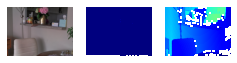

536/536 [==============================] - 923s 1s/step - batch: 267.5000 - size: 15.9963 - loss: 35.7210 - mae: 3.1728 - rmse: 4.8892 - abs_rel: 0.8154 - log10_mae: 0.4378 - log10_rmse: 0.4922 - val_loss: 14.7646 - val_mae: 3.0300 - val_rmse: 3.5290 - val_abs_rel: 0.7072 - val_log10_mae: 0.3717 - val_log10_rmse: 0.3980

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 13.5964 - mae: 2.6497 - rmse: 4.4983 - abs_rel: 0.6075 - log10_mae: 0.2980 - log10_rmse: 0.3592

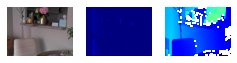

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 13.5964 - mae: 2.6497 - rmse: 4.4983 - abs_rel: 0.6075 - log10_mae: 0.2980 - log10_rmse: 0.3592 - val_loss: 6.7152 - val_mae: 2.6192 - val_rmse: 3.1369 - val_abs_rel: 0.5753 - val_log10_mae: 0.2802 - val_log10_rmse: 0.3061

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 6.1686 - mae: 2.3631 - rmse: 4.1840 - abs_rel: 0.5171 - log10_mae: 0.2404 - log10_rmse: 0.3015

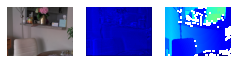

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 6.1686 - mae: 2.3631 - rmse: 4.1840 - abs_rel: 0.5171 - log10_mae: 0.2404 - log10_rmse: 0.3015 - val_loss: 3.0555 - val_mae: 2.3775 - val_rmse: 2.9107 - val_abs_rel: 0.5001 - val_log10_mae: 0.2349 - val_log10_rmse: 0.2614

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 2.8263 - mae: 2.1797 - rmse: 4.0336 - abs_rel: 0.4683 - log10_mae: 0.2081 - log10_rmse: 0.2694

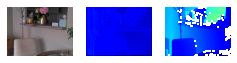

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 2.8263 - mae: 2.1797 - rmse: 4.0336 - abs_rel: 0.4683 - log10_mae: 0.2081 - log10_rmse: 0.2694 - val_loss: 1.4669 - val_mae: 2.0957 - val_rmse: 2.6392 - val_abs_rel: 0.4263 - val_log10_mae: 0.1896 - val_log10_rmse: 0.2165

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 5/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 1.4141 - mae: 2.0245 - rmse: 3.8459 - abs_rel: 0.4354 - log10_mae: 0.1833 - log10_rmse: 0.2424

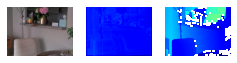

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 1.4141 - mae: 2.0245 - rmse: 3.8459 - abs_rel: 0.4354 - log10_mae: 0.1833 - log10_rmse: 0.2424 - val_loss: 0.8275 - val_mae: 2.0013 - val_rmse: 2.5486 - val_abs_rel: 0.4042 - val_log10_mae: 0.1753 - val_log10_rmse: 0.2022

Epoch 00006: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 6/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.8661 - mae: 1.8848 - rmse: 3.6675 - abs_rel: 0.4083 - log10_mae: 0.1628 - log10_rmse: 0.2185

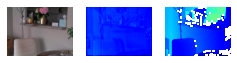

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.8661 - mae: 1.8848 - rmse: 3.6675 - abs_rel: 0.4083 - log10_mae: 0.1628 - log10_rmse: 0.2185 - val_loss: 0.5941 - val_mae: 1.8784 - val_rmse: 2.4171 - val_abs_rel: 0.3771 - val_log10_mae: 0.1594 - val_log10_rmse: 0.1853

Epoch 00007: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 7/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.6716 - mae: 1.7624 - rmse: 3.5107 - abs_rel: 0.3845 - log10_mae: 0.1469 - log10_rmse: 0.1994

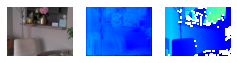

536/536 [==============================] - 512s 956ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.6716 - mae: 1.7624 - rmse: 3.5107 - abs_rel: 0.3845 - log10_mae: 0.1469 - log10_rmse: 0.1994 - val_loss: 0.5018 - val_mae: 1.5312 - val_rmse: 2.0734 - val_abs_rel: 0.3140 - val_log10_mae: 0.1175 - val_log10_rmse: 0.1449

Epoch 00008: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 8/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.5922 - mae: 1.6742 - rmse: 3.3857 - abs_rel: 0.3655 - log10_mae: 0.1359 - log10_rmse: 0.1857

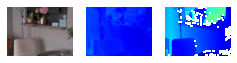

536/536 [==============================] - 502s 937ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.5922 - mae: 1.6742 - rmse: 3.3857 - abs_rel: 0.3655 - log10_mae: 0.1359 - log10_rmse: 0.1857 - val_loss: 0.4741 - val_mae: 1.7770 - val_rmse: 2.3061 - val_abs_rel: 0.3593 - val_log10_mae: 0.1473 - val_log10_rmse: 0.1726

Epoch 00009: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 9/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.5364 - mae: 1.5885 - rmse: 3.2989 - abs_rel: 0.3446 - log10_mae: 0.1259 - log10_rmse: 0.1741

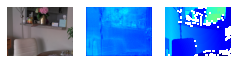

536/536 [==============================] - 506s 944ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.5364 - mae: 1.5885 - rmse: 3.2989 - abs_rel: 0.3446 - log10_mae: 0.1259 - log10_rmse: 0.1741 - val_loss: 0.4176 - val_mae: 1.5044 - val_rmse: 2.0335 - val_abs_rel: 0.3274 - val_log10_mae: 0.1149 - val_log10_rmse: 0.1413

Epoch 00010: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 10/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4893 - mae: 1.5163 - rmse: 3.2076 - abs_rel: 0.3288 - log10_mae: 0.1181 - log10_rmse: 0.1642

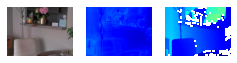

536/536 [==============================] - 503s 939ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4893 - mae: 1.5163 - rmse: 3.2076 - abs_rel: 0.3288 - log10_mae: 0.1181 - log10_rmse: 0.1642 - val_loss: 0.3912 - val_mae: 1.6727 - val_rmse: 2.1748 - val_abs_rel: 0.3390 - val_log10_mae: 0.1356 - val_log10_rmse: 0.1584

Epoch 00011: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 11/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4509 - mae: 1.4600 - rmse: 3.0787 - abs_rel: 0.3185 - log10_mae: 0.1121 - log10_rmse: 0.1565

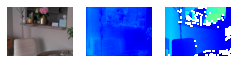

536/536 [==============================] - 513s 957ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4509 - mae: 1.4600 - rmse: 3.0787 - abs_rel: 0.3185 - log10_mae: 0.1121 - log10_rmse: 0.1565 - val_loss: 0.3473 - val_mae: 1.4890 - val_rmse: 2.0046 - val_abs_rel: 0.2922 - val_log10_mae: 0.1129 - val_log10_rmse: 0.1371

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 12/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4151 - mae: 1.4036 - rmse: 3.0287 - abs_rel: 0.3035 - log10_mae: 0.1060 - log10_rmse: 0.1495

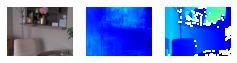

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4151 - mae: 1.4036 - rmse: 3.0287 - abs_rel: 0.3035 - log10_mae: 0.1060 - log10_rmse: 0.1495 - val_loss: 0.3230 - val_mae: 1.5166 - val_rmse: 2.0063 - val_abs_rel: 0.3088 - val_log10_mae: 0.1202 - val_log10_rmse: 0.1425

Epoch 00013: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 13/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3825 - mae: 1.3536 - rmse: 2.9457 - abs_rel: 0.2940 - log10_mae: 0.1011 - log10_rmse: 0.1432

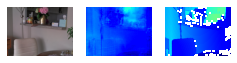

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3825 - mae: 1.3536 - rmse: 2.9457 - abs_rel: 0.2940 - log10_mae: 0.1011 - log10_rmse: 0.1432 - val_loss: 0.2953 - val_mae: 1.4606 - val_rmse: 1.9592 - val_abs_rel: 0.2871 - val_log10_mae: 0.1122 - val_log10_rmse: 0.1351

Epoch 00014: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 14/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3497 - mae: 1.3018 - rmse: 2.8582 - abs_rel: 0.2827 - log10_mae: 0.0962 - log10_rmse: 0.1369

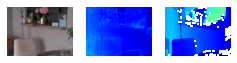

536/536 [==============================] - 516s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3497 - mae: 1.3018 - rmse: 2.8582 - abs_rel: 0.2827 - log10_mae: 0.0962 - log10_rmse: 0.1369 - val_loss: 0.2691 - val_mae: 1.3918 - val_rmse: 1.8905 - val_abs_rel: 0.2748 - val_log10_mae: 0.1048 - val_log10_rmse: 0.1278

Epoch 00015: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 15/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3248 - mae: 1.2640 - rmse: 2.7763 - abs_rel: 0.2768 - log10_mae: 0.0929 - log10_rmse: 0.1322

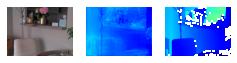

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3248 - mae: 1.2640 - rmse: 2.7763 - abs_rel: 0.2768 - log10_mae: 0.0929 - log10_rmse: 0.1322 - val_loss: 0.2543 - val_mae: 1.1482 - val_rmse: 1.6670 - val_abs_rel: 0.2422 - val_log10_mae: 0.0813 - val_log10_rmse: 0.1089

Epoch 00016: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 16/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2960 - mae: 1.2227 - rmse: 2.7249 - abs_rel: 0.2669 - log10_mae: 0.0889 - log10_rmse: 0.1273

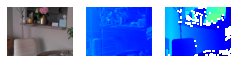

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2960 - mae: 1.2227 - rmse: 2.7249 - abs_rel: 0.2669 - log10_mae: 0.0889 - log10_rmse: 0.1273 - val_loss: 0.3090 - val_mae: 1.3481 - val_rmse: 1.8286 - val_abs_rel: 0.3080 - val_log10_mae: 0.1058 - val_log10_rmse: 0.1296

Epoch 00017: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 17/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2758 - mae: 1.1979 - rmse: 2.6448 - abs_rel: 0.2671 - log10_mae: 0.0877 - log10_rmse: 0.1251

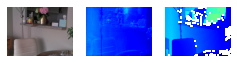

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2758 - mae: 1.1979 - rmse: 2.6448 - abs_rel: 0.2671 - log10_mae: 0.0877 - log10_rmse: 0.1251 - val_loss: 0.2228 - val_mae: 1.3612 - val_rmse: 1.8615 - val_abs_rel: 0.2641 - val_log10_mae: 0.1011 - val_log10_rmse: 0.1244

Epoch 00018: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 18/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2465 - mae: 1.1528 - rmse: 2.6023 - abs_rel: 0.2541 - log10_mae: 0.0831 - log10_rmse: 0.1192

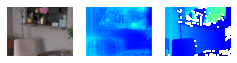

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2465 - mae: 1.1528 - rmse: 2.6023 - abs_rel: 0.2541 - log10_mae: 0.0831 - log10_rmse: 0.1192 - val_loss: 0.1989 - val_mae: 1.1654 - val_rmse: 1.6286 - val_abs_rel: 0.2735 - val_log10_mae: 0.0863 - val_log10_rmse: 0.1106

Epoch 00019: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 19/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2285 - mae: 1.1394 - rmse: 2.5375 - abs_rel: 0.2581 - log10_mae: 0.0831 - log10_rmse: 0.1181

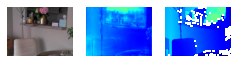

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2285 - mae: 1.1394 - rmse: 2.5375 - abs_rel: 0.2581 - log10_mae: 0.0831 - log10_rmse: 0.1181 - val_loss: 0.1743 - val_mae: 1.0947 - val_rmse: 1.5942 - val_abs_rel: 0.2184 - val_log10_mae: 0.0756 - val_log10_rmse: 0.1020

Epoch 00020: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 20/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2085 - mae: 1.1128 - rmse: 2.4729 - abs_rel: 0.2495 - log10_mae: 0.0803 - log10_rmse: 0.1151

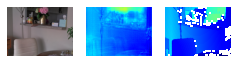

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2085 - mae: 1.1128 - rmse: 2.4729 - abs_rel: 0.2495 - log10_mae: 0.0803 - log10_rmse: 0.1151 - val_loss: 0.1664 - val_mae: 1.1273 - val_rmse: 1.6357 - val_abs_rel: 0.2395 - val_log10_mae: 0.0794 - val_log10_rmse: 0.1067

Epoch 00021: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 21/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1922 - mae: 1.0947 - rmse: 2.4667 - abs_rel: 0.2480 - log10_mae: 0.0791 - log10_rmse: 0.1132

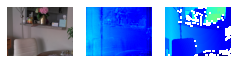

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1922 - mae: 1.0947 - rmse: 2.4667 - abs_rel: 0.2480 - log10_mae: 0.0791 - log10_rmse: 0.1132 - val_loss: 0.1466 - val_mae: 1.0283 - val_rmse: 1.5340 - val_abs_rel: 0.2036 - val_log10_mae: 0.0705 - val_log10_rmse: 0.0981

Epoch 00022: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 22/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1775 - mae: 1.0744 - rmse: 2.4147 - abs_rel: 0.2460 - log10_mae: 0.0779 - log10_rmse: 0.1112

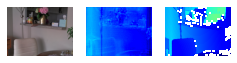

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1775 - mae: 1.0744 - rmse: 2.4147 - abs_rel: 0.2460 - log10_mae: 0.0779 - log10_rmse: 0.1112 - val_loss: 0.1601 - val_mae: 1.0534 - val_rmse: 1.5570 - val_abs_rel: 0.2131 - val_log10_mae: 0.0743 - val_log10_rmse: 0.1041

Epoch 00023: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 23/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1607 - mae: 1.0499 - rmse: 2.3443 - abs_rel: 0.2428 - log10_mae: 0.0762 - log10_rmse: 0.1082

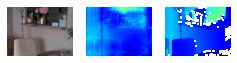

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1607 - mae: 1.0499 - rmse: 2.3443 - abs_rel: 0.2428 - log10_mae: 0.0762 - log10_rmse: 0.1082 - val_loss: 0.1380 - val_mae: 1.0539 - val_rmse: 1.5395 - val_abs_rel: 0.2286 - val_log10_mae: 0.0760 - val_log10_rmse: 0.1037

Epoch 00024: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 24/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1501 - mae: 1.0391 - rmse: 2.3247 - abs_rel: 0.2402 - log10_mae: 0.0754 - log10_rmse: 0.1070

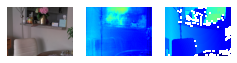

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1501 - mae: 1.0391 - rmse: 2.3247 - abs_rel: 0.2402 - log10_mae: 0.0754 - log10_rmse: 0.1070 - val_loss: 0.1250 - val_mae: 0.9969 - val_rmse: 1.5026 - val_abs_rel: 0.2152 - val_log10_mae: 0.0692 - val_log10_rmse: 0.0986

Epoch 00025: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 25/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1394 - mae: 1.0210 - rmse: 2.2838 - abs_rel: 0.2370 - log10_mae: 0.0742 - log10_rmse: 0.1055

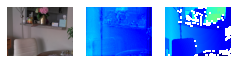

536/536 [==============================] - 503s 938ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1394 - mae: 1.0210 - rmse: 2.2838 - abs_rel: 0.2370 - log10_mae: 0.0742 - log10_rmse: 0.1055 - val_loss: 0.1195 - val_mae: 1.0252 - val_rmse: 1.5337 - val_abs_rel: 0.2030 - val_log10_mae: 0.0701 - val_log10_rmse: 0.0978

Epoch 00026: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 26/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1339 - mae: 1.0036 - rmse: 2.2265 - abs_rel: 0.2350 - log10_mae: 0.0729 - log10_rmse: 0.1037

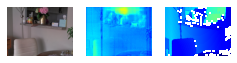

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1339 - mae: 1.0036 - rmse: 2.2265 - abs_rel: 0.2350 - log10_mae: 0.0729 - log10_rmse: 0.1037 - val_loss: 0.1454 - val_mae: 1.1120 - val_rmse: 1.5436 - val_abs_rel: 0.2973 - val_log10_mae: 0.0859 - val_log10_rmse: 0.1093

Epoch 00027: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 27/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1237 - mae: 0.9894 - rmse: 2.2284 - abs_rel: 0.2307 - log10_mae: 0.0717 - log10_rmse: 0.1021

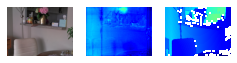

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1237 - mae: 0.9894 - rmse: 2.2284 - abs_rel: 0.2307 - log10_mae: 0.0717 - log10_rmse: 0.1021 - val_loss: 0.1474 - val_mae: 0.9807 - val_rmse: 1.4872 - val_abs_rel: 0.2010 - val_log10_mae: 0.0687 - val_log10_rmse: 0.0988

Epoch 00028: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 28/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1169 - mae: 0.9737 - rmse: 2.1955 - abs_rel: 0.2263 - log10_mae: 0.0703 - log10_rmse: 0.1001

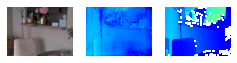

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1169 - mae: 0.9737 - rmse: 2.1955 - abs_rel: 0.2263 - log10_mae: 0.0703 - log10_rmse: 0.1001 - val_loss: 0.2034 - val_mae: 1.0389 - val_rmse: 1.4932 - val_abs_rel: 0.2724 - val_log10_mae: 0.0805 - val_log10_rmse: 0.1060

Epoch 00029: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 29/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1120 - mae: 0.9593 - rmse: 2.1630 - abs_rel: 0.2259 - log10_mae: 0.0698 - log10_rmse: 0.0993

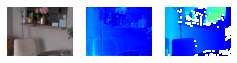

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1120 - mae: 0.9593 - rmse: 2.1630 - abs_rel: 0.2259 - log10_mae: 0.0698 - log10_rmse: 0.0993 - val_loss: 0.1022 - val_mae: 0.9977 - val_rmse: 1.4199 - val_abs_rel: 0.2316 - val_log10_mae: 0.0762 - val_log10_rmse: 0.0981

Epoch 00030: LearningRateScheduler reducing learning rate to 3.33333324912625e-05.
Epoch 30/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0965 - mae: 0.9110 - rmse: 2.0951 - abs_rel: 0.2114 - log10_mae: 0.0650 - log10_rmse: 0.0931

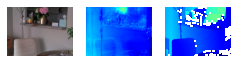

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0965 - mae: 0.9110 - rmse: 2.0951 - abs_rel: 0.2114 - log10_mae: 0.0650 - log10_rmse: 0.0931 - val_loss: 0.0927 - val_mae: 0.9225 - val_rmse: 1.4053 - val_abs_rel: 0.2052 - val_log10_mae: 0.0649 - val_log10_rmse: 0.0928

Epoch 00031: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 31/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0935 - mae: 0.8972 - rmse: 2.0672 - abs_rel: 0.2052 - log10_mae: 0.0636 - log10_rmse: 0.0916

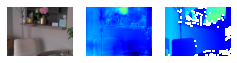

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0935 - mae: 0.8972 - rmse: 2.0672 - abs_rel: 0.2052 - log10_mae: 0.0636 - log10_rmse: 0.0916 - val_loss: 0.1148 - val_mae: 0.9874 - val_rmse: 1.4411 - val_abs_rel: 0.2260 - val_log10_mae: 0.0742 - val_log10_rmse: 0.1000

Epoch 00032: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 32/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0929 - mae: 0.8949 - rmse: 2.0461 - abs_rel: 0.2074 - log10_mae: 0.0640 - log10_rmse: 0.0916

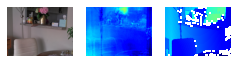

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0929 - mae: 0.8949 - rmse: 2.0461 - abs_rel: 0.2074 - log10_mae: 0.0640 - log10_rmse: 0.0916 - val_loss: 0.1457 - val_mae: 0.8820 - val_rmse: 1.4320 - val_abs_rel: 0.2203 - val_log10_mae: 0.0659 - val_log10_rmse: 0.0969

Epoch 00033: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 33/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0922 - mae: 0.8918 - rmse: 2.0363 - abs_rel: 0.2066 - log10_mae: 0.0636 - log10_rmse: 0.0912

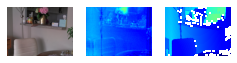

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0922 - mae: 0.8918 - rmse: 2.0363 - abs_rel: 0.2066 - log10_mae: 0.0636 - log10_rmse: 0.0912 - val_loss: 0.0989 - val_mae: 1.0083 - val_rmse: 1.5112 - val_abs_rel: 0.2168 - val_log10_mae: 0.0707 - val_log10_rmse: 0.0985

Epoch 00034: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 34/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0908 - mae: 0.8870 - rmse: 2.0461 - abs_rel: 0.2041 - log10_mae: 0.0631 - log10_rmse: 0.0906

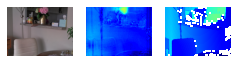

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0908 - mae: 0.8870 - rmse: 2.0461 - abs_rel: 0.2041 - log10_mae: 0.0631 - log10_rmse: 0.0906 - val_loss: 0.0999 - val_mae: 1.0753 - val_rmse: 1.5585 - val_abs_rel: 0.2152 - val_log10_mae: 0.0770 - val_log10_rmse: 0.1031

Epoch 00035: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 35/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0888 - mae: 0.8765 - rmse: 2.0344 - abs_rel: 0.2034 - log10_mae: 0.0626 - log10_rmse: 0.0899

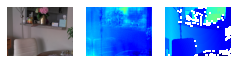

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0888 - mae: 0.8765 - rmse: 2.0344 - abs_rel: 0.2034 - log10_mae: 0.0626 - log10_rmse: 0.0899 - val_loss: 0.0965 - val_mae: 0.9097 - val_rmse: 1.3705 - val_abs_rel: 0.2233 - val_log10_mae: 0.0677 - val_log10_rmse: 0.0950

Epoch 00036: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 36/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0877 - mae: 0.8744 - rmse: 1.9913 - abs_rel: 0.2022 - log10_mae: 0.0623 - log10_rmse: 0.0893

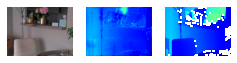

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0877 - mae: 0.8744 - rmse: 1.9913 - abs_rel: 0.2022 - log10_mae: 0.0623 - log10_rmse: 0.0893 - val_loss: 0.1037 - val_mae: 0.9334 - val_rmse: 1.4177 - val_abs_rel: 0.2019 - val_log10_mae: 0.0661 - val_log10_rmse: 0.0944

Epoch 00037: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 37/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0875 - mae: 0.8754 - rmse: 2.0147 - abs_rel: 0.2031 - log10_mae: 0.0623 - log10_rmse: 0.0893

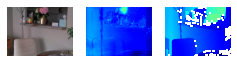

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0875 - mae: 0.8754 - rmse: 2.0147 - abs_rel: 0.2031 - log10_mae: 0.0623 - log10_rmse: 0.0893 - val_loss: 0.0949 - val_mae: 0.9857 - val_rmse: 1.4583 - val_abs_rel: 0.2031 - val_log10_mae: 0.0701 - val_log10_rmse: 0.0961

Epoch 00038: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 38/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0860 - mae: 0.8645 - rmse: 1.9858 - abs_rel: 0.2006 - log10_mae: 0.0615 - log10_rmse: 0.0884

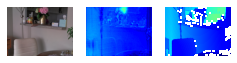

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0860 - mae: 0.8645 - rmse: 1.9858 - abs_rel: 0.2006 - log10_mae: 0.0615 - log10_rmse: 0.0884 - val_loss: 0.0955 - val_mae: 1.0063 - val_rmse: 1.4712 - val_abs_rel: 0.2106 - val_log10_mae: 0.0722 - val_log10_rmse: 0.0972

Epoch 00039: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 39/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0832 - mae: 0.8512 - rmse: 1.9557 - abs_rel: 0.1990 - log10_mae: 0.0609 - log10_rmse: 0.0871

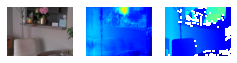

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0832 - mae: 0.8512 - rmse: 1.9557 - abs_rel: 0.1990 - log10_mae: 0.0609 - log10_rmse: 0.0871 - val_loss: 0.0928 - val_mae: 0.8902 - val_rmse: 1.3912 - val_abs_rel: 0.2100 - val_log10_mae: 0.0640 - val_log10_rmse: 0.0940

Epoch 00040: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 40/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0834 - mae: 0.8555 - rmse: 1.9571 - abs_rel: 0.1991 - log10_mae: 0.0610 - log10_rmse: 0.0874

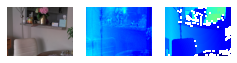

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0834 - mae: 0.8555 - rmse: 1.9571 - abs_rel: 0.1991 - log10_mae: 0.0610 - log10_rmse: 0.0874 - val_loss: 0.0827 - val_mae: 0.9010 - val_rmse: 1.3639 - val_abs_rel: 0.2190 - val_log10_mae: 0.0653 - val_log10_rmse: 0.0925

Epoch 00041: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 41/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0833 - mae: 0.8522 - rmse: 1.9377 - abs_rel: 0.2001 - log10_mae: 0.0611 - log10_rmse: 0.0873

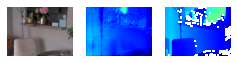

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0833 - mae: 0.8522 - rmse: 1.9377 - abs_rel: 0.2001 - log10_mae: 0.0611 - log10_rmse: 0.0873 - val_loss: 0.0927 - val_mae: 0.9517 - val_rmse: 1.4360 - val_abs_rel: 0.2048 - val_log10_mae: 0.0680 - val_log10_rmse: 0.0954

Epoch 00042: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 42/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0816 - mae: 0.8436 - rmse: 1.9031 - abs_rel: 0.1983 - log10_mae: 0.0605 - log10_rmse: 0.0865

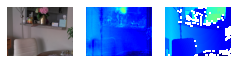

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0816 - mae: 0.8436 - rmse: 1.9031 - abs_rel: 0.1983 - log10_mae: 0.0605 - log10_rmse: 0.0865 - val_loss: 0.1129 - val_mae: 1.0077 - val_rmse: 1.5864 - val_abs_rel: 0.2120 - val_log10_mae: 0.0714 - val_log10_rmse: 0.1001

Epoch 00043: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 43/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0804 - mae: 0.8431 - rmse: 1.9139 - abs_rel: 0.1988 - log10_mae: 0.0606 - log10_rmse: 0.0863

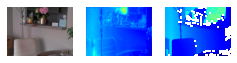

536/536 [==============================] - 516s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0804 - mae: 0.8431 - rmse: 1.9139 - abs_rel: 0.1988 - log10_mae: 0.0606 - log10_rmse: 0.0863 - val_loss: 0.1047 - val_mae: 0.9049 - val_rmse: 1.3892 - val_abs_rel: 0.2101 - val_log10_mae: 0.0644 - val_log10_rmse: 0.0932

Epoch 00044: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 44/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0779 - mae: 0.8295 - rmse: 1.9064 - abs_rel: 0.1950 - log10_mae: 0.0593 - log10_rmse: 0.0850

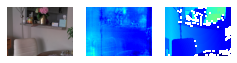

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0779 - mae: 0.8295 - rmse: 1.9064 - abs_rel: 0.1950 - log10_mae: 0.0593 - log10_rmse: 0.0850 - val_loss: 0.0962 - val_mae: 0.8717 - val_rmse: 1.3417 - val_abs_rel: 0.2208 - val_log10_mae: 0.0660 - val_log10_rmse: 0.0951

Epoch 00045: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 45/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0792 - mae: 0.8400 - rmse: 1.9201 - abs_rel: 0.1965 - log10_mae: 0.0599 - log10_rmse: 0.0858

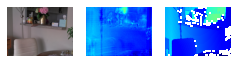

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0792 - mae: 0.8400 - rmse: 1.9201 - abs_rel: 0.1965 - log10_mae: 0.0599 - log10_rmse: 0.0858 - val_loss: 0.0791 - val_mae: 0.8684 - val_rmse: 1.3383 - val_abs_rel: 0.2088 - val_log10_mae: 0.0631 - val_log10_rmse: 0.0917

Epoch 00046: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 46/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0781 - mae: 0.8308 - rmse: 1.8941 - abs_rel: 0.1957 - log10_mae: 0.0596 - log10_rmse: 0.0851

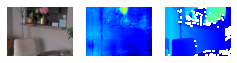

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0781 - mae: 0.8308 - rmse: 1.8941 - abs_rel: 0.1957 - log10_mae: 0.0596 - log10_rmse: 0.0851 - val_loss: 0.1022 - val_mae: 1.0166 - val_rmse: 1.4944 - val_abs_rel: 0.2216 - val_log10_mae: 0.0749 - val_log10_rmse: 0.1024

Epoch 00047: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 47/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0764 - mae: 0.8207 - rmse: 1.8467 - abs_rel: 0.1945 - log10_mae: 0.0590 - log10_rmse: 0.0839

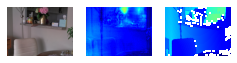

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0764 - mae: 0.8207 - rmse: 1.8467 - abs_rel: 0.1945 - log10_mae: 0.0590 - log10_rmse: 0.0839 - val_loss: 0.0923 - val_mae: 1.0237 - val_rmse: 1.5272 - val_abs_rel: 0.2298 - val_log10_mae: 0.0779 - val_log10_rmse: 0.1024

Epoch 00048: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 48/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0778 - mae: 0.8308 - rmse: 1.8942 - abs_rel: 0.1968 - log10_mae: 0.0597 - log10_rmse: 0.0855

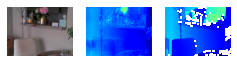

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0778 - mae: 0.8308 - rmse: 1.8942 - abs_rel: 0.1968 - log10_mae: 0.0597 - log10_rmse: 0.0855 - val_loss: 0.0859 - val_mae: 0.8027 - val_rmse: 1.3229 - val_abs_rel: 0.1939 - val_log10_mae: 0.0587 - val_log10_rmse: 0.0889

Epoch 00049: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 49/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0751 - mae: 0.8166 - rmse: 1.8946 - abs_rel: 0.1933 - log10_mae: 0.0585 - log10_rmse: 0.0837

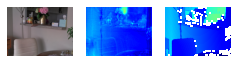

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0751 - mae: 0.8166 - rmse: 1.8946 - abs_rel: 0.1933 - log10_mae: 0.0585 - log10_rmse: 0.0837 - val_loss: 0.0745 - val_mae: 0.8707 - val_rmse: 1.3139 - val_abs_rel: 0.2043 - val_log10_mae: 0.0638 - val_log10_rmse: 0.0888

Epoch 00050: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 50/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0731 - mae: 0.8047 - rmse: 1.8362 - abs_rel: 0.1912 - log10_mae: 0.0578 - log10_rmse: 0.0822

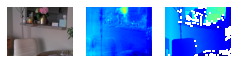

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0731 - mae: 0.8047 - rmse: 1.8362 - abs_rel: 0.1912 - log10_mae: 0.0578 - log10_rmse: 0.0822 - val_loss: 0.1821 - val_mae: 0.8847 - val_rmse: 1.5146 - val_abs_rel: 0.2246 - val_log10_mae: 0.0649 - val_log10_rmse: 0.0982

Epoch 00051: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 51/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0735 - mae: 0.8070 - rmse: 1.8349 - abs_rel: 0.1923 - log10_mae: 0.0580 - log10_rmse: 0.0827

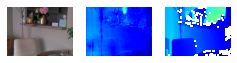

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0735 - mae: 0.8070 - rmse: 1.8349 - abs_rel: 0.1923 - log10_mae: 0.0580 - log10_rmse: 0.0827 - val_loss: 0.0841 - val_mae: 0.9508 - val_rmse: 1.4140 - val_abs_rel: 0.2117 - val_log10_mae: 0.0710 - val_log10_rmse: 0.0972

Epoch 00052: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 52/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0732 - mae: 0.8040 - rmse: 1.8225 - abs_rel: 0.1933 - log10_mae: 0.0582 - log10_rmse: 0.0829

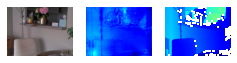

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0732 - mae: 0.8040 - rmse: 1.8225 - abs_rel: 0.1933 - log10_mae: 0.0582 - log10_rmse: 0.0829 - val_loss: 0.0797 - val_mae: 0.9570 - val_rmse: 1.4147 - val_abs_rel: 0.2084 - val_log10_mae: 0.0700 - val_log10_rmse: 0.0956

Epoch 00053: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 53/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0734 - mae: 0.8107 - rmse: 1.8271 - abs_rel: 0.1942 - log10_mae: 0.0585 - log10_rmse: 0.0831

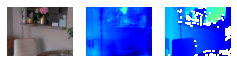

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0734 - mae: 0.8107 - rmse: 1.8271 - abs_rel: 0.1942 - log10_mae: 0.0585 - log10_rmse: 0.0831 - val_loss: 0.1321 - val_mae: 0.9973 - val_rmse: 1.5022 - val_abs_rel: 0.2198 - val_log10_mae: 0.0742 - val_log10_rmse: 0.1018

Epoch 00054: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 54/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0720 - mae: 0.8023 - rmse: 1.8233 - abs_rel: 0.1931 - log10_mae: 0.0580 - log10_rmse: 0.0825

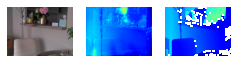

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0720 - mae: 0.8023 - rmse: 1.8233 - abs_rel: 0.1931 - log10_mae: 0.0580 - log10_rmse: 0.0825 - val_loss: 0.0802 - val_mae: 0.9237 - val_rmse: 1.3993 - val_abs_rel: 0.2150 - val_log10_mae: 0.0662 - val_log10_rmse: 0.0944

Epoch 00055: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 55/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0708 - mae: 0.7935 - rmse: 1.8078 - abs_rel: 0.1902 - log10_mae: 0.0572 - log10_rmse: 0.0816

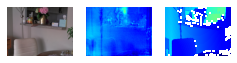

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0708 - mae: 0.7935 - rmse: 1.8078 - abs_rel: 0.1902 - log10_mae: 0.0572 - log10_rmse: 0.0816 - val_loss: 0.1037 - val_mae: 0.8949 - val_rmse: 1.4649 - val_abs_rel: 0.2063 - val_log10_mae: 0.0651 - val_log10_rmse: 0.0955

Epoch 00056: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 56/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0706 - mae: 0.7942 - rmse: 1.8091 - abs_rel: 0.1912 - log10_mae: 0.0576 - log10_rmse: 0.0818

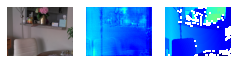

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0706 - mae: 0.7942 - rmse: 1.8091 - abs_rel: 0.1912 - log10_mae: 0.0576 - log10_rmse: 0.0818 - val_loss: 0.1311 - val_mae: 0.8633 - val_rmse: 1.3668 - val_abs_rel: 0.2180 - val_log10_mae: 0.0644 - val_log10_rmse: 0.0939

Epoch 00057: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 57/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0705 - mae: 0.7936 - rmse: 1.8147 - abs_rel: 0.1902 - log10_mae: 0.0572 - log10_rmse: 0.0817

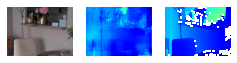

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0705 - mae: 0.7936 - rmse: 1.8147 - abs_rel: 0.1902 - log10_mae: 0.0572 - log10_rmse: 0.0817 - val_loss: 0.0730 - val_mae: 0.8289 - val_rmse: 1.2800 - val_abs_rel: 0.2026 - val_log10_mae: 0.0617 - val_log10_rmse: 0.0894

Epoch 00058: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 58/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0687 - mae: 0.7831 - rmse: 1.7792 - abs_rel: 0.1894 - log10_mae: 0.0567 - log10_rmse: 0.0808

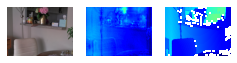

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0687 - mae: 0.7831 - rmse: 1.7792 - abs_rel: 0.1894 - log10_mae: 0.0567 - log10_rmse: 0.0808 - val_loss: 0.1120 - val_mae: 0.9877 - val_rmse: 1.6476 - val_abs_rel: 0.2286 - val_log10_mae: 0.0722 - val_log10_rmse: 0.1021

Epoch 00059: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 59/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0689 - mae: 0.7827 - rmse: 1.7821 - abs_rel: 0.1893 - log10_mae: 0.0567 - log10_rmse: 0.0808

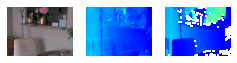

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0689 - mae: 0.7827 - rmse: 1.7821 - abs_rel: 0.1893 - log10_mae: 0.0567 - log10_rmse: 0.0808 - val_loss: 0.0888 - val_mae: 0.8704 - val_rmse: 1.3886 - val_abs_rel: 0.2042 - val_log10_mae: 0.0620 - val_log10_rmse: 0.0915

Epoch 00060: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 60/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0643 - mae: 0.7649 - rmse: 1.7663 - abs_rel: 0.1822 - log10_mae: 0.0546 - log10_rmse: 0.0785

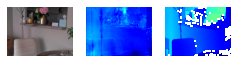

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0643 - mae: 0.7649 - rmse: 1.7663 - abs_rel: 0.1822 - log10_mae: 0.0546 - log10_rmse: 0.0785 - val_loss: 0.0909 - val_mae: 0.9511 - val_rmse: 1.4884 - val_abs_rel: 0.2124 - val_log10_mae: 0.0691 - val_log10_rmse: 0.0978

Epoch 00061: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 61/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0640 - mae: 0.7627 - rmse: 1.7816 - abs_rel: 0.1811 - log10_mae: 0.0542 - log10_rmse: 0.0784

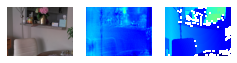

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0640 - mae: 0.7627 - rmse: 1.7816 - abs_rel: 0.1811 - log10_mae: 0.0542 - log10_rmse: 0.0784 - val_loss: 0.0755 - val_mae: 0.8548 - val_rmse: 1.3649 - val_abs_rel: 0.2072 - val_log10_mae: 0.0623 - val_log10_rmse: 0.0919

Epoch 00062: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 62/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0630 - mae: 0.7539 - rmse: 1.7422 - abs_rel: 0.1799 - log10_mae: 0.0538 - log10_rmse: 0.0775

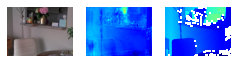

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0630 - mae: 0.7539 - rmse: 1.7422 - abs_rel: 0.1799 - log10_mae: 0.0538 - log10_rmse: 0.0775 - val_loss: 0.1206 - val_mae: 0.8690 - val_rmse: 1.5314 - val_abs_rel: 0.2139 - val_log10_mae: 0.0631 - val_log10_rmse: 0.0954

Epoch 00063: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 63/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0640 - mae: 0.7624 - rmse: 1.7562 - abs_rel: 0.1829 - log10_mae: 0.0546 - log10_rmse: 0.0785

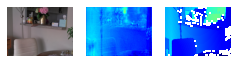

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0640 - mae: 0.7624 - rmse: 1.7562 - abs_rel: 0.1829 - log10_mae: 0.0546 - log10_rmse: 0.0785 - val_loss: 0.0707 - val_mae: 0.8391 - val_rmse: 1.2916 - val_abs_rel: 0.2205 - val_log10_mae: 0.0633 - val_log10_rmse: 0.0904

Epoch 00064: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 64/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0634 - mae: 0.7593 - rmse: 1.7500 - abs_rel: 0.1813 - log10_mae: 0.0542 - log10_rmse: 0.0782

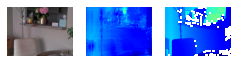

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0634 - mae: 0.7593 - rmse: 1.7500 - abs_rel: 0.1813 - log10_mae: 0.0542 - log10_rmse: 0.0782 - val_loss: 0.0907 - val_mae: 0.9146 - val_rmse: 1.4678 - val_abs_rel: 0.2129 - val_log10_mae: 0.0670 - val_log10_rmse: 0.0959

Epoch 00065: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 65/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0624 - mae: 0.7525 - rmse: 1.7279 - abs_rel: 0.1802 - log10_mae: 0.0539 - log10_rmse: 0.0775

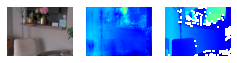

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0624 - mae: 0.7525 - rmse: 1.7279 - abs_rel: 0.1802 - log10_mae: 0.0539 - log10_rmse: 0.0775 - val_loss: 0.0739 - val_mae: 0.8599 - val_rmse: 1.3584 - val_abs_rel: 0.2113 - val_log10_mae: 0.0633 - val_log10_rmse: 0.0919

Epoch 00066: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 66/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0627 - mae: 0.7535 - rmse: 1.7103 - abs_rel: 0.1812 - log10_mae: 0.0542 - log10_rmse: 0.0775

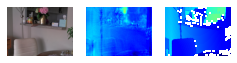

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0627 - mae: 0.7535 - rmse: 1.7103 - abs_rel: 0.1812 - log10_mae: 0.0542 - log10_rmse: 0.0775 - val_loss: 0.0844 - val_mae: 0.8804 - val_rmse: 1.4155 - val_abs_rel: 0.2176 - val_log10_mae: 0.0644 - val_log10_rmse: 0.0943

Epoch 00067: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 67/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0614 - mae: 0.7495 - rmse: 1.7331 - abs_rel: 0.1787 - log10_mae: 0.0533 - log10_rmse: 0.0766

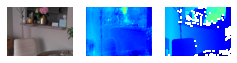

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0614 - mae: 0.7495 - rmse: 1.7331 - abs_rel: 0.1787 - log10_mae: 0.0533 - log10_rmse: 0.0766 - val_loss: 0.1277 - val_mae: 0.8631 - val_rmse: 1.4978 - val_abs_rel: 0.2282 - val_log10_mae: 0.0646 - val_log10_rmse: 0.0954

Epoch 00068: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 68/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0622 - mae: 0.7524 - rmse: 1.7296 - abs_rel: 0.1815 - log10_mae: 0.0540 - log10_rmse: 0.0776

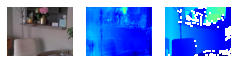

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0622 - mae: 0.7524 - rmse: 1.7296 - abs_rel: 0.1815 - log10_mae: 0.0540 - log10_rmse: 0.0776 - val_loss: 0.1062 - val_mae: 0.8904 - val_rmse: 1.5341 - val_abs_rel: 0.2111 - val_log10_mae: 0.0642 - val_log10_rmse: 0.0958

Epoch 00069: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 69/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0615 - mae: 0.7486 - rmse: 1.7276 - abs_rel: 0.1788 - log10_mae: 0.0534 - log10_rmse: 0.0769

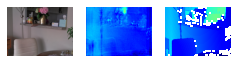

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0615 - mae: 0.7486 - rmse: 1.7276 - abs_rel: 0.1788 - log10_mae: 0.0534 - log10_rmse: 0.0769 - val_loss: 0.0856 - val_mae: 0.8644 - val_rmse: 1.4223 - val_abs_rel: 0.2022 - val_log10_mae: 0.0624 - val_log10_rmse: 0.0926

Epoch 00070: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 70/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0627 - mae: 0.7536 - rmse: 1.7221 - abs_rel: 0.1798 - log10_mae: 0.0539 - log10_rmse: 0.0777

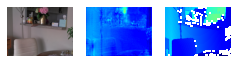

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0627 - mae: 0.7536 - rmse: 1.7221 - abs_rel: 0.1798 - log10_mae: 0.0539 - log10_rmse: 0.0777 - val_loss: 0.0732 - val_mae: 0.8807 - val_rmse: 1.3370 - val_abs_rel: 0.2108 - val_log10_mae: 0.0657 - val_log10_rmse: 0.0913

Epoch 00071: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 71/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0620 - mae: 0.7496 - rmse: 1.7320 - abs_rel: 0.1791 - log10_mae: 0.0534 - log10_rmse: 0.0770

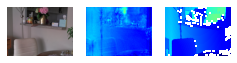

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0620 - mae: 0.7496 - rmse: 1.7320 - abs_rel: 0.1791 - log10_mae: 0.0534 - log10_rmse: 0.0770 - val_loss: 0.0913 - val_mae: 0.8527 - val_rmse: 1.4165 - val_abs_rel: 0.2062 - val_log10_mae: 0.0615 - val_log10_rmse: 0.0921

Epoch 00072: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 72/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0607 - mae: 0.7392 - rmse: 1.7043 - abs_rel: 0.1774 - log10_mae: 0.0529 - log10_rmse: 0.0763

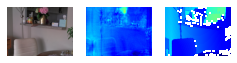

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0607 - mae: 0.7392 - rmse: 1.7043 - abs_rel: 0.1774 - log10_mae: 0.0529 - log10_rmse: 0.0763 - val_loss: 0.0796 - val_mae: 0.8850 - val_rmse: 1.3944 - val_abs_rel: 0.2148 - val_log10_mae: 0.0650 - val_log10_rmse: 0.0934

Epoch 00073: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 73/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0609 - mae: 0.7437 - rmse: 1.7033 - abs_rel: 0.1791 - log10_mae: 0.0534 - log10_rmse: 0.0767

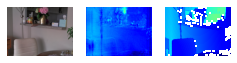

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0609 - mae: 0.7437 - rmse: 1.7033 - abs_rel: 0.1791 - log10_mae: 0.0534 - log10_rmse: 0.0767 - val_loss: 0.0955 - val_mae: 0.9257 - val_rmse: 1.4627 - val_abs_rel: 0.2076 - val_log10_mae: 0.0666 - val_log10_rmse: 0.0953

Epoch 00074: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 74/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0614 - mae: 0.7468 - rmse: 1.7152 - abs_rel: 0.1789 - log10_mae: 0.0534 - log10_rmse: 0.0769

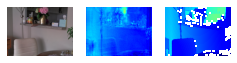

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0614 - mae: 0.7468 - rmse: 1.7152 - abs_rel: 0.1789 - log10_mae: 0.0534 - log10_rmse: 0.0769 - val_loss: 0.0846 - val_mae: 0.8172 - val_rmse: 1.3928 - val_abs_rel: 0.2107 - val_log10_mae: 0.0604 - val_log10_rmse: 0.0915

Epoch 00075: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 75/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0603 - mae: 0.7380 - rmse: 1.6984 - abs_rel: 0.1776 - log10_mae: 0.0530 - log10_rmse: 0.0763

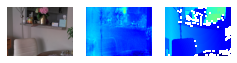

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0603 - mae: 0.7380 - rmse: 1.6984 - abs_rel: 0.1776 - log10_mae: 0.0530 - log10_rmse: 0.0763 - val_loss: 0.0859 - val_mae: 0.8840 - val_rmse: 1.5509 - val_abs_rel: 0.2260 - val_log10_mae: 0.0648 - val_log10_rmse: 0.0973

Epoch 00079: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 79/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0602 - mae: 0.7401 - rmse: 1.6977 - abs_rel: 0.1786 - log10_mae: 0.0531 - log10_rmse: 0.0763

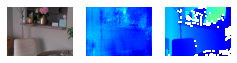

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0602 - mae: 0.7401 - rmse: 1.6977 - abs_rel: 0.1786 - log10_mae: 0.0531 - log10_rmse: 0.0763 - val_loss: 0.0785 - val_mae: 0.8941 - val_rmse: 1.4570 - val_abs_rel: 0.2227 - val_log10_mae: 0.0660 - val_log10_rmse: 0.0953

Epoch 00080: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 80/100
278/536 [==============>...............] - ETA: 4:06 - batch: 138.5000 - size: 16.0000 - loss: 0.0595 - mae: 0.7389 - rmse: 1.6952 - abs_rel: 0.1790 - log10_mae: 0.0536 - log10_rmse: 0.0770

In [ ]:
history = run_epochs(100, 30)

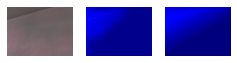

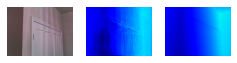

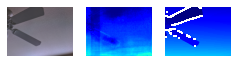

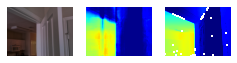

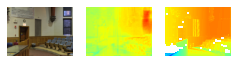

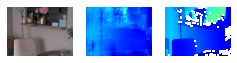

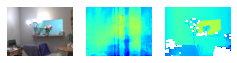

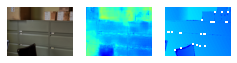

In [17]:
display_samples()


Epoch 00051: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 51/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0543 - mae: 0.2794 - rmse: 1.6758 - log10_rmse: 0.0846 - log10_mae: 0.0032

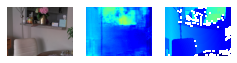

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0543 - mae: 0.2794 - rmse: 1.6758 - log10_rmse: 0.0846 - log10_mae: 0.0032 - val_loss: 0.0621 - val_mae: 0.5262 - val_rmse: 1.3535 - val_log10_rmse: 0.0918 - val_log10_mae: 0.0239

Epoch 00052: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 52/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0550 - mae: 0.2859 - rmse: 1.7089 - log10_rmse: 0.0852 - log10_mae: 0.0031

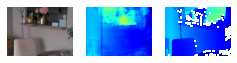

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0550 - mae: 0.2859 - rmse: 1.7089 - log10_rmse: 0.0852 - log10_mae: 0.0031 - val_loss: 0.0593 - val_mae: 0.4349 - val_rmse: 1.3174 - val_log10_rmse: 0.0889 - val_log10_mae: 0.0163

Epoch 00053: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 53/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0550 - mae: 0.2838 - rmse: 1.7279 - log10_rmse: 0.0850 - log10_mae: 0.0028

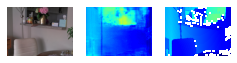

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0550 - mae: 0.2838 - rmse: 1.7279 - log10_rmse: 0.0850 - log10_mae: 0.0028 - val_loss: 0.0586 - val_mae: 0.4541 - val_rmse: 1.2930 - val_log10_rmse: 0.0887 - val_log10_mae: 0.0184

Epoch 00054: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 54/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2777 - rmse: 1.6823 - log10_rmse: 0.0844 - log10_mae: 0.0029

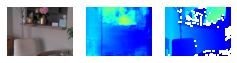

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2777 - rmse: 1.6823 - log10_rmse: 0.0844 - log10_mae: 0.0029 - val_loss: 0.0618 - val_mae: 0.3878 - val_rmse: 1.3251 - val_log10_rmse: 0.0897 - val_log10_mae: 0.0115

Epoch 00055: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 55/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0543 - mae: 0.2809 - rmse: 1.6867 - log10_rmse: 0.0846 - log10_mae: 0.0028

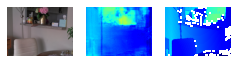

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0543 - mae: 0.2809 - rmse: 1.6867 - log10_rmse: 0.0846 - log10_mae: 0.0028 - val_loss: 0.0616 - val_mae: 0.4647 - val_rmse: 1.3320 - val_log10_rmse: 0.0901 - val_log10_mae: 0.0187

Epoch 00056: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 56/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0547 - mae: 0.2829 - rmse: 1.6910 - log10_rmse: 0.0847 - log10_mae: 0.0030

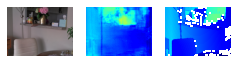

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0547 - mae: 0.2829 - rmse: 1.6910 - log10_rmse: 0.0847 - log10_mae: 0.0030 - val_loss: 0.0586 - val_mae: 0.4614 - val_rmse: 1.2996 - val_log10_rmse: 0.0886 - val_log10_mae: 0.0184

Epoch 00057: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 57/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2809 - rmse: 1.6979 - log10_rmse: 0.0845 - log10_mae: 0.0030

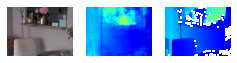

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2809 - rmse: 1.6979 - log10_rmse: 0.0845 - log10_mae: 0.0030 - val_loss: 0.0597 - val_mae: 0.4865 - val_rmse: 1.3172 - val_log10_rmse: 0.0896 - val_log10_mae: 0.0207

Epoch 00058: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 58/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2791 - rmse: 1.6872 - log10_rmse: 0.0844 - log10_mae: 0.0028

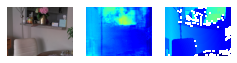

536/536 [==============================] - 519s 969ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2791 - rmse: 1.6872 - log10_rmse: 0.0844 - log10_mae: 0.0028 - val_loss: 0.0578 - val_mae: 0.5011 - val_rmse: 1.2966 - val_log10_rmse: 0.0885 - val_log10_mae: 0.0222

Epoch 00059: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 59/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0555 - mae: 0.2833 - rmse: 1.7048 - log10_rmse: 0.0854 - log10_mae: 0.0034

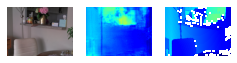

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0555 - mae: 0.2833 - rmse: 1.7048 - log10_rmse: 0.0854 - log10_mae: 0.0034 - val_loss: 0.0600 - val_mae: 0.4681 - val_rmse: 1.3185 - val_log10_rmse: 0.0895 - val_log10_mae: 0.0184

Epoch 00060: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 60/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0539 - mae: 0.2785 - rmse: 1.6716 - log10_rmse: 0.0841 - log10_mae: 0.0029

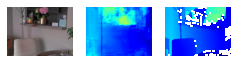

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0539 - mae: 0.2785 - rmse: 1.6716 - log10_rmse: 0.0841 - log10_mae: 0.0029 - val_loss: 0.0597 - val_mae: 0.4655 - val_rmse: 1.3169 - val_log10_rmse: 0.0893 - val_log10_mae: 0.0196

Epoch 00061: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 61/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0549 - mae: 0.2840 - rmse: 1.7029 - log10_rmse: 0.0849 - log10_mae: 0.0032

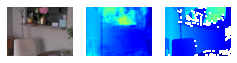

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0549 - mae: 0.2840 - rmse: 1.7029 - log10_rmse: 0.0849 - log10_mae: 0.0032 - val_loss: 0.0578 - val_mae: 0.4487 - val_rmse: 1.3045 - val_log10_rmse: 0.0885 - val_log10_mae: 0.0178

Epoch 00062: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 62/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0536 - mae: 0.2765 - rmse: 1.6768 - log10_rmse: 0.0839 - log10_mae: 0.0029

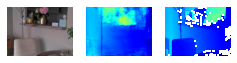

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0536 - mae: 0.2765 - rmse: 1.6768 - log10_rmse: 0.0839 - log10_mae: 0.0029 - val_loss: 0.0599 - val_mae: 0.4735 - val_rmse: 1.3168 - val_log10_rmse: 0.0894 - val_log10_mae: 0.0183

Epoch 00063: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 63/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2847 - rmse: 1.7129 - log10_rmse: 0.0846 - log10_mae: 0.0030

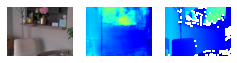

536/536 [==============================] - 505s 942ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2847 - rmse: 1.7129 - log10_rmse: 0.0846 - log10_mae: 0.0030 - val_loss: 0.0571 - val_mae: 0.3619 - val_rmse: 1.2595 - val_log10_rmse: 0.0874 - val_log10_mae: 0.0105

Epoch 00064: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 64/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0544 - mae: 0.2807 - rmse: 1.6988 - log10_rmse: 0.0844 - log10_mae: 0.0029

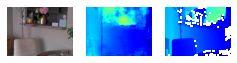

536/536 [==============================] - 505s 942ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0544 - mae: 0.2807 - rmse: 1.6988 - log10_rmse: 0.0844 - log10_mae: 0.0029 - val_loss: 0.0610 - val_mae: 0.4597 - val_rmse: 1.3356 - val_log10_rmse: 0.0896 - val_log10_mae: 0.0181

Epoch 00065: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 65/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2839 - rmse: 1.7066 - log10_rmse: 0.0846 - log10_mae: 0.0031

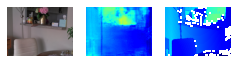

536/536 [==============================] - 504s 940ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2839 - rmse: 1.7066 - log10_rmse: 0.0846 - log10_mae: 0.0031 - val_loss: 0.0569 - val_mae: 0.4045 - val_rmse: 1.2628 - val_log10_rmse: 0.0876 - val_log10_mae: 0.0139

Epoch 00066: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 66/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2796 - rmse: 1.6839 - log10_rmse: 0.0846 - log10_mae: 0.0032

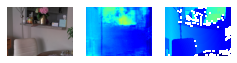

536/536 [==============================] - 503s 939ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0545 - mae: 0.2796 - rmse: 1.6839 - log10_rmse: 0.0846 - log10_mae: 0.0032 - val_loss: 0.0579 - val_mae: 0.4266 - val_rmse: 1.2853 - val_log10_rmse: 0.0878 - val_log10_mae: 0.0158

Epoch 00067: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 67/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0542 - mae: 0.2758 - rmse: 1.6699 - log10_rmse: 0.0843 - log10_mae: 0.0030

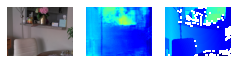

536/536 [==============================] - 508s 948ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0542 - mae: 0.2758 - rmse: 1.6699 - log10_rmse: 0.0843 - log10_mae: 0.0030 - val_loss: 0.0565 - val_mae: 0.4450 - val_rmse: 1.2708 - val_log10_rmse: 0.0878 - val_log10_mae: 0.0165

Epoch 00068: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 68/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2831 - rmse: 1.6924 - log10_rmse: 0.0841 - log10_mae: 0.0033

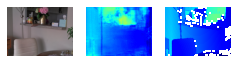

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2831 - rmse: 1.6924 - log10_rmse: 0.0841 - log10_mae: 0.0033 - val_loss: 0.0579 - val_mae: 0.3561 - val_rmse: 1.2787 - val_log10_rmse: 0.0877 - val_log10_mae: 0.0088

Epoch 00069: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 69/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2830 - rmse: 1.6905 - log10_rmse: 0.0843 - log10_mae: 0.0033

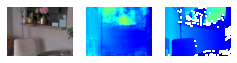

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2830 - rmse: 1.6905 - log10_rmse: 0.0843 - log10_mae: 0.0033 - val_loss: 0.0579 - val_mae: 0.3656 - val_rmse: 1.2781 - val_log10_rmse: 0.0879 - val_log10_mae: 0.0099

Epoch 00070: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 70/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0557 - mae: 0.2834 - rmse: 1.7039 - log10_rmse: 0.0852 - log10_mae: 0.0033

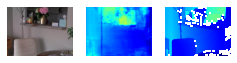

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0557 - mae: 0.2834 - rmse: 1.7039 - log10_rmse: 0.0852 - log10_mae: 0.0033 - val_loss: 0.0621 - val_mae: 0.4080 - val_rmse: 1.3382 - val_log10_rmse: 0.0898 - val_log10_mae: 0.0136

Epoch 00071: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 71/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0538 - mae: 0.2784 - rmse: 1.6835 - log10_rmse: 0.0841 - log10_mae: 0.0032

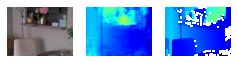

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0538 - mae: 0.2784 - rmse: 1.6835 - log10_rmse: 0.0841 - log10_mae: 0.0032 - val_loss: 0.0582 - val_mae: 0.4117 - val_rmse: 1.2902 - val_log10_rmse: 0.0882 - val_log10_mae: 0.0150

Epoch 00072: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 72/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0544 - mae: 0.2815 - rmse: 1.7039 - log10_rmse: 0.0846 - log10_mae: 0.0031

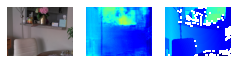

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0544 - mae: 0.2815 - rmse: 1.7039 - log10_rmse: 0.0846 - log10_mae: 0.0031 - val_loss: 0.0604 - val_mae: 0.3968 - val_rmse: 1.3371 - val_log10_rmse: 0.0889 - val_log10_mae: 0.0135

Epoch 00073: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 73/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0536 - mae: 0.2718 - rmse: 1.6588 - log10_rmse: 0.0837 - log10_mae: 0.0029

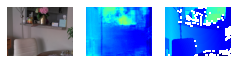

536/536 [==============================] - 498s 929ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0536 - mae: 0.2718 - rmse: 1.6588 - log10_rmse: 0.0837 - log10_mae: 0.0029 - val_loss: 0.0602 - val_mae: 0.4377 - val_rmse: 1.3421 - val_log10_rmse: 0.0892 - val_log10_mae: 0.0155

Epoch 00074: LearningRateScheduler reducing learning rate to 9.765625463842298e-07.
Epoch 74/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0538 - mae: 0.2796 - rmse: 1.6720 - log10_rmse: 0.0840 - log10_mae: 0.0031

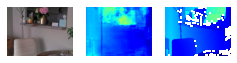

536/536 [==============================] - 507s 945ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0538 - mae: 0.2796 - rmse: 1.6720 - log10_rmse: 0.0840 - log10_mae: 0.0031 - val_loss: 0.0596 - val_mae: 0.4631 - val_rmse: 1.3214 - val_log10_rmse: 0.0895 - val_log10_mae: 0.0204

Epoch 00075: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 75/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2721 - rmse: 1.6597 - log10_rmse: 0.0834 - log10_mae: 0.0032

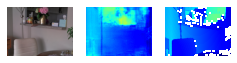

536/536 [==============================] - 505s 943ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2721 - rmse: 1.6597 - log10_rmse: 0.0834 - log10_mae: 0.0032 - val_loss: 0.0598 - val_mae: 0.3972 - val_rmse: 1.3156 - val_log10_rmse: 0.0885 - val_log10_mae: 0.0128

Epoch 00076: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 76/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0546 - mae: 0.2901 - rmse: 1.7311 - log10_rmse: 0.0847 - log10_mae: 0.0032

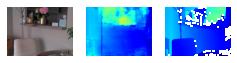

536/536 [==============================] - 505s 941ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0546 - mae: 0.2901 - rmse: 1.7311 - log10_rmse: 0.0847 - log10_mae: 0.0032 - val_loss: 0.0608 - val_mae: 0.3714 - val_rmse: 1.3342 - val_log10_rmse: 0.0890 - val_log10_mae: 0.0116

Epoch 00077: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 77/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2719 - rmse: 1.6708 - log10_rmse: 0.0835 - log10_mae: 0.0029

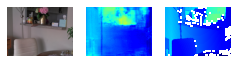

536/536 [==============================] - 501s 935ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2719 - rmse: 1.6708 - log10_rmse: 0.0835 - log10_mae: 0.0029 - val_loss: 0.0601 - val_mae: 0.4397 - val_rmse: 1.3378 - val_log10_rmse: 0.0895 - val_log10_mae: 0.0172

Epoch 00078: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 78/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2739 - rmse: 1.6702 - log10_rmse: 0.0838 - log10_mae: 0.0031

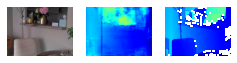

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0541 - mae: 0.2739 - rmse: 1.6702 - log10_rmse: 0.0838 - log10_mae: 0.0031 - val_loss: 0.0599 - val_mae: 0.4315 - val_rmse: 1.3414 - val_log10_rmse: 0.0891 - val_log10_mae: 0.0161

Epoch 00079: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 79/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0531 - mae: 0.2829 - rmse: 1.6850 - log10_rmse: 0.0833 - log10_mae: 0.0030

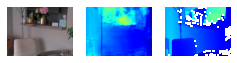

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0531 - mae: 0.2829 - rmse: 1.6850 - log10_rmse: 0.0833 - log10_mae: 0.0030 - val_loss: 0.0587 - val_mae: 0.4223 - val_rmse: 1.3222 - val_log10_rmse: 0.0887 - val_log10_mae: 0.0154

Epoch 00080: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 80/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2833 - rmse: 1.7041 - log10_rmse: 0.0837 - log10_mae: 0.0031

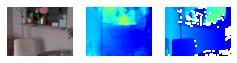

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2833 - rmse: 1.7041 - log10_rmse: 0.0837 - log10_mae: 0.0031 - val_loss: 0.0592 - val_mae: 0.3961 - val_rmse: 1.3301 - val_log10_rmse: 0.0887 - val_log10_mae: 0.0135

Epoch 00081: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 81/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2703 - rmse: 1.6382 - log10_rmse: 0.0835 - log10_mae: 0.0028

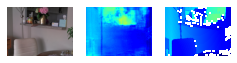

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2703 - rmse: 1.6382 - log10_rmse: 0.0835 - log10_mae: 0.0028 - val_loss: 0.0598 - val_mae: 0.4300 - val_rmse: 1.3482 - val_log10_rmse: 0.0892 - val_log10_mae: 0.0163

Epoch 00082: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 82/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2796 - rmse: 1.6770 - log10_rmse: 0.0831 - log10_mae: 0.0029

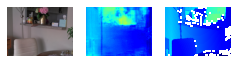

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2796 - rmse: 1.6770 - log10_rmse: 0.0831 - log10_mae: 0.0029 - val_loss: 0.0597 - val_mae: 0.4270 - val_rmse: 1.3401 - val_log10_rmse: 0.0890 - val_log10_mae: 0.0159

Epoch 00083: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 83/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0546 - mae: 0.2863 - rmse: 1.7020 - log10_rmse: 0.0845 - log10_mae: 0.0033

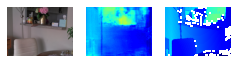

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0546 - mae: 0.2863 - rmse: 1.7020 - log10_rmse: 0.0845 - log10_mae: 0.0033 - val_loss: 0.0645 - val_mae: 0.4235 - val_rmse: 1.4194 - val_log10_rmse: 0.0906 - val_log10_mae: 0.0166

Epoch 00084: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 84/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2736 - rmse: 1.6712 - log10_rmse: 0.0840 - log10_mae: 0.0030

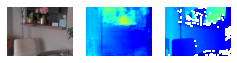

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2736 - rmse: 1.6712 - log10_rmse: 0.0840 - log10_mae: 0.0030 - val_loss: 0.0635 - val_mae: 0.4075 - val_rmse: 1.3867 - val_log10_rmse: 0.0902 - val_log10_mae: 0.0143

Epoch 00085: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 85/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2808 - rmse: 1.6666 - log10_rmse: 0.0835 - log10_mae: 0.0032

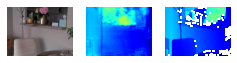

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2808 - rmse: 1.6666 - log10_rmse: 0.0835 - log10_mae: 0.0032 - val_loss: 0.0583 - val_mae: 0.4463 - val_rmse: 1.3097 - val_log10_rmse: 0.0888 - val_log10_mae: 0.0179

Epoch 00086: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 86/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2692 - rmse: 1.6528 - log10_rmse: 0.0832 - log10_mae: 0.0028

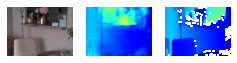

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2692 - rmse: 1.6528 - log10_rmse: 0.0832 - log10_mae: 0.0028 - val_loss: 0.0640 - val_mae: 0.4482 - val_rmse: 1.4022 - val_log10_rmse: 0.0909 - val_log10_mae: 0.0180

Epoch 00087: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 87/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2799 - rmse: 1.6673 - log10_rmse: 0.0836 - log10_mae: 0.0031

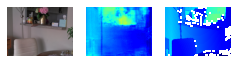

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2799 - rmse: 1.6673 - log10_rmse: 0.0836 - log10_mae: 0.0031 - val_loss: 0.0621 - val_mae: 0.4195 - val_rmse: 1.3829 - val_log10_rmse: 0.0899 - val_log10_mae: 0.0156

Epoch 00088: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 88/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0539 - mae: 0.2838 - rmse: 1.6833 - log10_rmse: 0.0841 - log10_mae: 0.0032

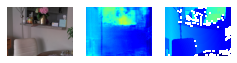

536/536 [==============================] - 518s 967ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0539 - mae: 0.2838 - rmse: 1.6833 - log10_rmse: 0.0841 - log10_mae: 0.0032 - val_loss: 0.0660 - val_mae: 0.4074 - val_rmse: 1.4472 - val_log10_rmse: 0.0911 - val_log10_mae: 0.0153

Epoch 00089: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 89/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0531 - mae: 0.2750 - rmse: 1.6710 - log10_rmse: 0.0832 - log10_mae: 0.0030

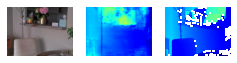

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0531 - mae: 0.2750 - rmse: 1.6710 - log10_rmse: 0.0832 - log10_mae: 0.0030 - val_loss: 0.0618 - val_mae: 0.4032 - val_rmse: 1.3928 - val_log10_rmse: 0.0900 - val_log10_mae: 0.0136

Epoch 00090: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 90/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2716 - rmse: 1.6595 - log10_rmse: 0.0833 - log10_mae: 0.0028

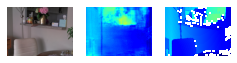

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0530 - mae: 0.2716 - rmse: 1.6595 - log10_rmse: 0.0833 - log10_mae: 0.0028 - val_loss: 0.0592 - val_mae: 0.4412 - val_rmse: 1.3431 - val_log10_rmse: 0.0893 - val_log10_mae: 0.0166

Epoch 00091: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 91/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0525 - mae: 0.2755 - rmse: 1.6595 - log10_rmse: 0.0828 - log10_mae: 0.0029

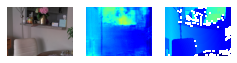

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0525 - mae: 0.2755 - rmse: 1.6595 - log10_rmse: 0.0828 - log10_mae: 0.0029 - val_loss: 0.0613 - val_mae: 0.4107 - val_rmse: 1.3622 - val_log10_rmse: 0.0897 - val_log10_mae: 0.0144

Epoch 00092: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 92/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2788 - rmse: 1.6686 - log10_rmse: 0.0833 - log10_mae: 0.0030

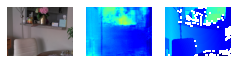

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2788 - rmse: 1.6686 - log10_rmse: 0.0833 - log10_mae: 0.0030 - val_loss: 0.0585 - val_mae: 0.4357 - val_rmse: 1.3281 - val_log10_rmse: 0.0888 - val_log10_mae: 0.0164

Epoch 00093: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 93/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2833 - rmse: 1.6867 - log10_rmse: 0.0838 - log10_mae: 0.0031

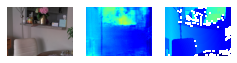

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0535 - mae: 0.2833 - rmse: 1.6867 - log10_rmse: 0.0838 - log10_mae: 0.0031 - val_loss: 0.0588 - val_mae: 0.4167 - val_rmse: 1.3314 - val_log10_rmse: 0.0887 - val_log10_mae: 0.0150

Epoch 00094: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 94/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0529 - mae: 0.2757 - rmse: 1.6632 - log10_rmse: 0.0831 - log10_mae: 0.0030

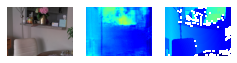

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0529 - mae: 0.2757 - rmse: 1.6632 - log10_rmse: 0.0831 - log10_mae: 0.0030 - val_loss: 0.0593 - val_mae: 0.4490 - val_rmse: 1.3453 - val_log10_rmse: 0.0892 - val_log10_mae: 0.0172

Epoch 00095: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 95/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2751 - rmse: 1.6679 - log10_rmse: 0.0834 - log10_mae: 0.0029

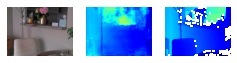

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2751 - rmse: 1.6679 - log10_rmse: 0.0834 - log10_mae: 0.0029 - val_loss: 0.0607 - val_mae: 0.4367 - val_rmse: 1.3715 - val_log10_rmse: 0.0897 - val_log10_mae: 0.0164

Epoch 00096: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 96/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2767 - rmse: 1.6759 - log10_rmse: 0.0835 - log10_mae: 0.0029

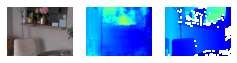

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2767 - rmse: 1.6759 - log10_rmse: 0.0835 - log10_mae: 0.0029 - val_loss: 0.0601 - val_mae: 0.4670 - val_rmse: 1.3523 - val_log10_rmse: 0.0897 - val_log10_mae: 0.0194

Epoch 00097: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 97/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2822 - rmse: 1.6838 - log10_rmse: 0.0836 - log10_mae: 0.0032

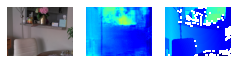

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2822 - rmse: 1.6838 - log10_rmse: 0.0836 - log10_mae: 0.0032 - val_loss: 0.0596 - val_mae: 0.4515 - val_rmse: 1.3457 - val_log10_rmse: 0.0893 - val_log10_mae: 0.0179

Epoch 00098: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 98/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2837 - rmse: 1.6742 - log10_rmse: 0.0841 - log10_mae: 0.0033

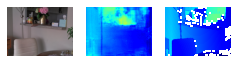

536/536 [==============================] - 517s 965ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0540 - mae: 0.2837 - rmse: 1.6742 - log10_rmse: 0.0841 - log10_mae: 0.0033 - val_loss: 0.0606 - val_mae: 0.4223 - val_rmse: 1.3562 - val_log10_rmse: 0.0893 - val_log10_mae: 0.0160

Epoch 00099: LearningRateScheduler reducing learning rate to 2.4414063659605745e-07.
Epoch 99/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2748 - rmse: 1.6714 - log10_rmse: 0.0835 - log10_mae: 0.0031

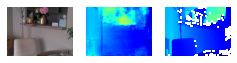

536/536 [==============================] - 518s 966ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0533 - mae: 0.2748 - rmse: 1.6714 - log10_rmse: 0.0835 - log10_mae: 0.0031 - val_loss: 0.0619 - val_mae: 0.4133 - val_rmse: 1.3741 - val_log10_rmse: 0.0901 - val_log10_mae: 0.0148

Epoch 00100: LearningRateScheduler reducing learning rate to 6.103515914901436e-08.
Epoch 100/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2811 - rmse: 1.6680 - log10_rmse: 0.0836 - log10_mae: 0.0032

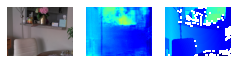

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0534 - mae: 0.2811 - rmse: 1.6680 - log10_rmse: 0.0836 - log10_mae: 0.0032 - val_loss: 0.0570 - val_mae: 0.4194 - val_rmse: 1.2944 - val_log10_rmse: 0.0882 - val_log10_mae: 0.0150


In [18]:
history2 = run_epochs(50, 25)

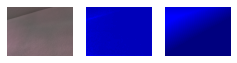

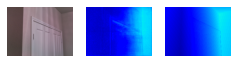

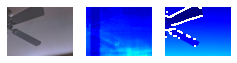

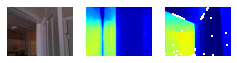

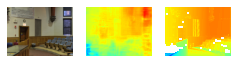

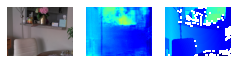

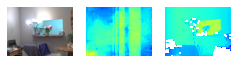

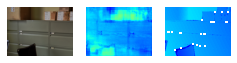

In [20]:
display_samples()

In [18]:
model.evaluate([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask], [val_depth])

[0.08336598038673401, 0.8469187, 1.5949117, 0.21918882, 0.0627245, 0.096648216]

In [19]:
[m.name for m in model.metrics]

['mae', 'rmse', 'abs_rel', 'log10_mae', 'log10_rmse']


Epoch 00051: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 51/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1084

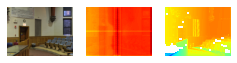

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1084 - val_loss: 0.1450

Epoch 00052: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 52/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1089

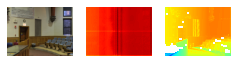

536/536 [==============================] - 74s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1089 - val_loss: 0.1613

Epoch 00053: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 53/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1082

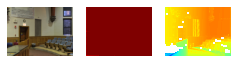

536/536 [==============================] - 74s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1082 - val_loss: 0.1230

Epoch 00054: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 54/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1114

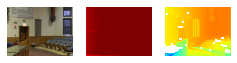

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1114 - val_loss: 0.1375

Epoch 00055: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 55/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1069

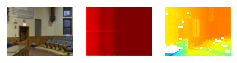

536/536 [==============================] - 74s 138ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1069 - val_loss: 0.0993

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 56/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1082

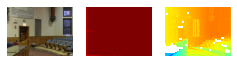

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1082 - val_loss: 0.1240

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 57/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1065

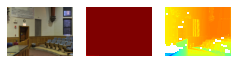

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1065 - val_loss: 0.1111

Epoch 00058: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 58/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1067

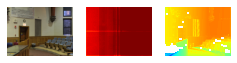

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1067 - val_loss: 0.1814

Epoch 00059: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 59/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1086

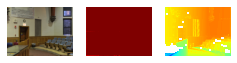

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1086 - val_loss: 0.1028

Epoch 00060: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 60/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1087

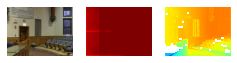

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1087 - val_loss: 0.1451

Epoch 00061: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 61/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1066

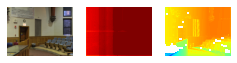

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1066 - val_loss: 0.1118

Epoch 00062: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 62/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1058

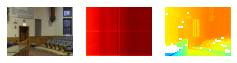

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1058 - val_loss: 0.1393

Epoch 00063: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 63/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1075

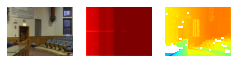

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1075 - val_loss: 0.1032

Epoch 00064: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 64/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1105

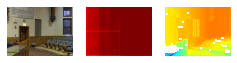

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1105 - val_loss: 0.1148

Epoch 00065: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 65/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1066

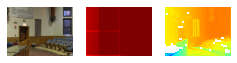

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1066 - val_loss: 0.1412

Epoch 00066: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 66/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1069

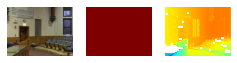

536/536 [==============================] - 74s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1069 - val_loss: 0.1225

Epoch 00067: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 67/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1073

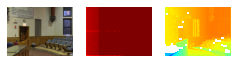

536/536 [==============================] - 74s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1073 - val_loss: 0.1698

Epoch 00068: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 68/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1058

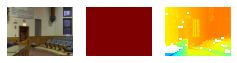

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1058 - val_loss: 0.1085

Epoch 00069: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 69/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1079

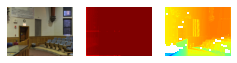

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1079 - val_loss: 0.1187

Epoch 00070: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 70/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1054

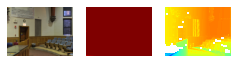

536/536 [==============================] - 74s 138ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1054 - val_loss: 0.1212

Epoch 00071: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 71/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1053

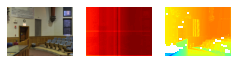

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1053 - val_loss: 0.1259

Epoch 00072: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 72/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1051

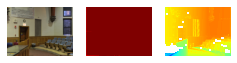

536/536 [==============================] - 74s 138ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1051 - val_loss: 0.1324

Epoch 00073: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 73/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1041

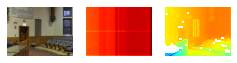

536/536 [==============================] - 74s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1041 - val_loss: 0.1189

Epoch 00074: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 74/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1038

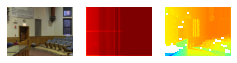

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1038 - val_loss: 0.1246

Epoch 00075: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 75/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1048

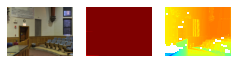

536/536 [==============================] - 74s 138ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1048 - val_loss: 0.1418

Epoch 00076: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 76/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1057

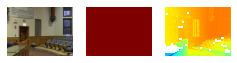

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1057 - val_loss: 0.1151

Epoch 00077: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 77/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1061

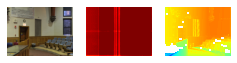

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1061 - val_loss: 0.1275

Epoch 00078: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 78/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1055

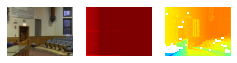

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1055 - val_loss: 0.1418

Epoch 00079: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 79/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1066

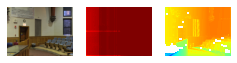

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1066 - val_loss: 0.1812

Epoch 00080: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 80/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1038

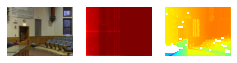

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1038 - val_loss: 0.1539

Epoch 00081: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 81/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1017

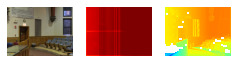

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1017 - val_loss: 0.1285

Epoch 00082: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 82/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1055

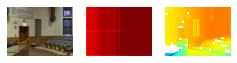

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1055 - val_loss: 0.1493

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 83/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1019

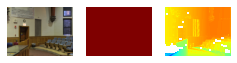

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1019 - val_loss: 0.1198

Epoch 00084: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 84/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1038

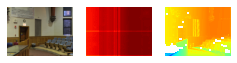

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1038 - val_loss: 0.1478

Epoch 00085: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 85/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1049

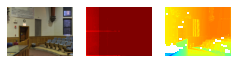

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1049 - val_loss: 0.1387

Epoch 00086: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 86/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0999

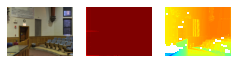

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0999 - val_loss: 0.1155

Epoch 00087: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 87/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1032

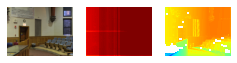

536/536 [==============================] - 72s 135ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1032 - val_loss: 0.1345

Epoch 00088: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 88/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1013

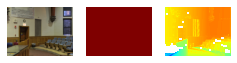

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1013 - val_loss: 0.1205

Epoch 00089: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 89/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0992

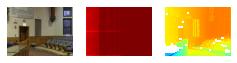

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0992 - val_loss: 0.1192

Epoch 00090: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 90/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1022

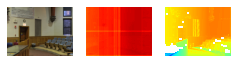

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1022 - val_loss: 0.1137

Epoch 00091: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 91/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1012

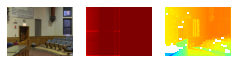

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1012 - val_loss: 0.1502

Epoch 00092: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 92/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1014

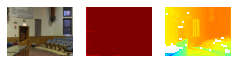

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1014 - val_loss: 0.1173

Epoch 00093: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 93/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1006

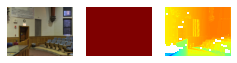

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1006 - val_loss: 0.1434

Epoch 00094: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 94/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0984

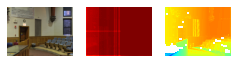

536/536 [==============================] - 73s 137ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0984 - val_loss: 0.1148

Epoch 00095: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 95/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1007

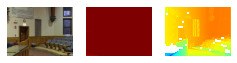

536/536 [==============================] - 73s 136ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1007 - val_loss: 0.1158

Epoch 00096: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 96/100
469/536 [=========================>....] - ETA: 9s - batch: 234.0000 - size: 15.9957 - loss: 0.0982

In [ ]:
run_epochs(50)

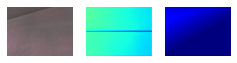

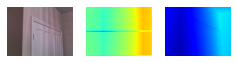

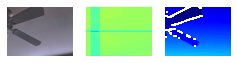

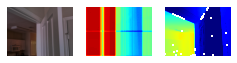

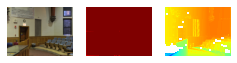

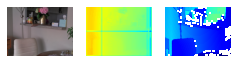

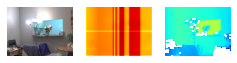

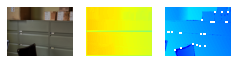

In [144]:
display_samples()

In [ ]:
run_epochs(50)

In [ ]:
display_samples()